In [1]:
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

In [9]:
device = 'cpu'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transforms = v2.Compose([
    v2.ToTensor(),
])

train_complete_set = torchvision.datasets.MNIST('./datasets', train=True, transform=transforms, download=True)
train_set, val_set = random_split(train_complete_set, [0.95, 0.05], torch.Generator().manual_seed(42))

test_set = torchvision.datasets.MNIST('./datasets', train=False, transform=transforms, download=True)

c:\Users\F\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
batch_size = 256

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
class Solver:
    def __init__(self, model, lr=1e-1, reg=0.0, optim=torch.optim.Adam, batch_size=batch_size, criterion=nn.CrossEntropyLoss, print_every=100):
        self.lr = lr
        self.reg = reg
        self.model = model
        self.batch_size = batch_size
        self.optim = optim(model.parameters(), lr=lr, weight_decay=reg)
        self.criterion = criterion()
        self.dataloaders = {}
        self.loss_history = []
        self.print_every = print_every

        self.anneal_counter = 0
        self.last_anneal_idx = 0
        self.max_anneal_count = 3

    def set_data_loader(self, loader, split):
        self.dataloaders[split] = loader

    def estimate_loss(self, split):
        dataloader = self.dataloaders[split]

        if dataloader == None:
            return -1.0

        self.model.eval()
        avg_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                if i % 5000 == 0 and i > 0:
                    break
                images, _ = data
                N = images.shape[0]
                images = images.to(device)

                logits = self.model(images)
                loss = self.criterion(logits, images.reshape(N, -1))
                avg_loss += loss.item()

        self.model.train()
        return avg_loss / len(dataloader)
    
    def anneal_learning_rate(self):
        num_losses = len(self.loss_history)
        if (self.anneal_counter == self.max_anneal_count
            or num_losses < 3
            or num_losses - self.last_anneal_idx < 3):
            return

        train = [l[0] for l in self.loss_history]
        arr = np.array(train[-3:])
        if arr.std() >= 1e-4:
            return

        self.last_anneal_idx = num_losses
        self.anneal_counter += 1
        print(f"Annealing learning_rate {self.lr} by 10. New learning rate {self.lr / 10}. Anneal count {self.anneal_counter} / {self.max_anneal_count}.")
        self.lr /= 10

    def train(self, loader, epochs=1):
        for e in range(epochs):
            for i, data in enumerate(loader):
                if i % self.print_every == 0 and i > 0:
                    train_loss = self.estimate_loss('train')
                    val_loss = self.estimate_loss('val')
                    
                    print(f"epoch: {e} iter: {i} train_loss: {train_loss} val_loss: {val_loss}")

                    self.loss_history.append((train_loss, val_loss))
                    self.anneal_learning_rate()

                images, _ = data
                N = images.shape[0]
                images = images.to(device)

                self.optim.zero_grad()

                logits = self.model(images)
                loss = self.criterion(logits, images.reshape(N, -1))
                loss.backward()
                self.optim.step()


In [6]:
class Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_chananels = out_channels

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels, 128, device=device),
            nn.GELU(),
            nn.Linear(128, 64, device=device),
            nn.GELU(),
            nn.Linear(64, out_channels, device=device),
        )

        self.decoder = nn.Sequential(
            nn.Linear(out_channels, 64, device=device),
            nn.GELU(),
            nn.Linear(64, 128, device=device),
            nn.GELU(),
            nn.Linear(128, in_channels, device=device),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(self.encoder(x))
        return x
    
    def decode(self, embd):
        assert(embd.shape[1] == self.out_chananels)

        return self.decoder(embd)


In [10]:
from itertools import product

out_channels = [10, 20, 30, 40, 50, 64]
epochs = 10
learning_rates = [1e-1, 1e-2, 3e-3, 3e-4, 4e-5]

losses = {}
for out, lr in product(out_channels, learning_rates):
    print(f"Training for out_channels = {out}, learning_rate = {lr}")
    model = Net(784, out)
    solver = Solver(model, lr=lr, batch_size=batch_size, criterion=nn.MSELoss)
    solver.set_data_loader(train_loader, 'train')
    solver.set_data_loader(val_loader, 'val')

    solver.train(train_loader, epochs)

    losses[(out, lr)] = [solver.loss_history, model]

Training for out_channels = 10, learning_rate = 0.1


KeyboardInterrupt: 

In [11]:
# hyperparams found from sweep
# out_channels = [10, 20, 30, 40, 50, 64]
# learning_rates = [1e-1, 1e-2, 3e-3, 3e-4, 4e-5]

out = 20
lr = 3e-3
epochs = 5

print(f"Training for out_channels = {out}, learning_rate = {lr}")
best_model = Net(784, out)
solver = Solver(best_model, lr=lr, batch_size=batch_size, criterion=nn.MSELoss)
solver.set_data_loader(train_loader, 'train')
solver.set_data_loader(val_loader, 'val')

solver.train(train_loader, epochs)

losses[(out, lr)] = [solver.loss_history, best_model]

Training for out_channels = 20, learning_rate = 0.003
epoch: 0 iter: 100 train_loss: 0.05517809034529823 val_loss: 0.05477451253682375
epoch: 0 iter: 200 train_loss: 0.03827032508671017 val_loss: 0.03790573558459679
epoch: 1 iter: 100 train_loss: 0.028654712816124004 val_loss: 0.02859603613615036
epoch: 1 iter: 200 train_loss: 0.023188187101763996 val_loss: 0.023213086804995935
epoch: 2 iter: 100 train_loss: 0.019022477331316526 val_loss: 0.019148039631545544
epoch: 2 iter: 200 train_loss: 0.016708646261972698 val_loss: 0.016974913111577433
epoch: 3 iter: 100 train_loss: 0.014608994844649404 val_loss: 0.014875918704395493
epoch: 3 iter: 200 train_loss: 0.013266764869370536 val_loss: 0.013564235608403882
epoch: 4 iter: 100 train_loss: 0.012056438895485326 val_loss: 0.012348567213242253
epoch: 4 iter: 200 train_loss: 0.011364292683322065 val_loss: 0.011711845252042016


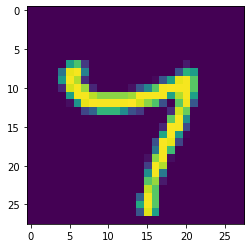

In [14]:

img = train_set[84][0]
plt.imshow(img.reshape(28, 28))


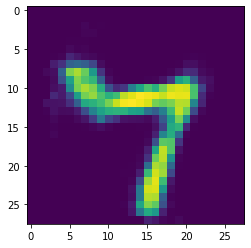

In [15]:
img = img.to(device).reshape(1, 784)
out = best_model(img)
plt.imshow(out.reshape(28, 28).cpu().detach().numpy())

In [ ]:
f = "autoencoder-mnist.pth"
torch.save({
    "solver": solver,
    "checkpoint": best_model,
}, f)

In [ ]:
loaded_model_data = torch.load(f)
best_model = loaded_model_data["checkpoint"]
best_model.to(device)

In [ ]:
img = torch.randn(1, 784, device=device)
out = best_model(img)
plt.imshow(out.reshape(28, 28).cpu().detach().numpy())